# SETD2 proteomics cis comparison

SETD2 is a tumor suppressor and the "main enzyme generating H3K36me3, a specific tag for epigenetic transcriptional activation" which is also involved in DNA repair pathways. SETD2 is involved with chromatin remodeling and DNA repair (regulating mismatch repair in G1, and required for repair of double- strand breaks). More informatiion can be found at the  Uniprot webpage: https://www.uniprot.org/uniprot/Q9BYW2

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Kidney Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
rc_object = cptac.RenalCcrcc()
desired_cutoff = 0.1

renal_freq_mut = al.get_frequently_mutated(rc_object, cutoff = desired_cutoff)
renal_freq_mut.loc[renal_freq_mut['Gene'] == 'SETD2']

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
3,SETD2,0.136364,0.018182,0.118182


## Step 3: Select SETD2, a frequently mutated gene

In [3]:
gene = 'SETD2'

## Step 4: Select proteomics

In [18]:
omics = rc_object.get_proteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [5]:
rc_status = f.format_cis_comparison_data(rc_object, 'proteomics', gene)

In [6]:
omics_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

         Comparison   P_Value
0  SETD2_proteomics  0.000078


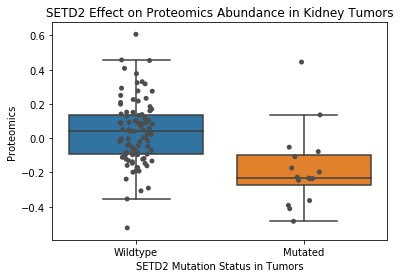

In [7]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
cis_boxplot = sns.boxplot(data = rc_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Kidney Tumors")
cis_boxplot = sns.stripplot(data= rc_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

SETD2 proteomic abundance decreased in the SETD2 mutated samples compared to the wildtype.

Repeat the above steps this time comparing missence and truncation mutation types.

In [8]:
rc_type = f.get_missence_truncation_comparison(rc_object, 'proteomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)
# ? not enough data?

Doing t-test comparison

No significant comparisons.
None


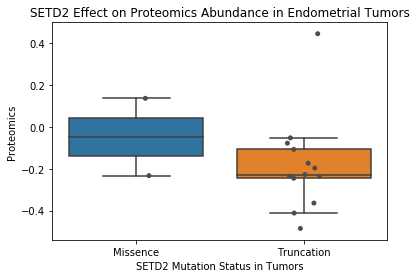

In [9]:
rc_cis_boxplot = sns.boxplot(data = rc_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= rc_type, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Missence","Truncation"])
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

#  Compare common mutations

Find the common mutation types and compare them to the wildtype tumors.

In [4]:
# Count all mutations (including all mutations in a sample)
somatic_mutations = rc_object.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
count_all_mut = gene_mutations['Mutation'].value_counts()
count_all_mut

Nonsense_Mutation    6
Frame_Shift_Del      4
Splice_Site          3
Missense_Mutation    2
Silent               1
Name: Mutation, dtype: int64

In [5]:
# count real measurements of omics data 
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene)
tumors = mutation_prot.loc[mutation_prot['Sample_Status'] == 'Tumor']                                                  
measured_omics = tumors.dropna(axis=0)
counts = measured_omics[gene+'_Mutation'].value_counts()
counts

[Wildtype_Tumor]       94
[Nonsense_Mutation]     6
[Frame_Shift_Del]       4
[Splice_Site]           3
[Missense_Mutation]     2
[Silent]                1
Name: SETD2_Mutation, dtype: int64

In [6]:
common_mutations = count_all_mut[count_all_mut.apply(lambda x: x > 4)] # check mut (have data in more than 1 sample)
print(common_mutations)

common_mut_list = list(common_mutations.index) #list of lists
common_mut_list = [''.join(x) for x in common_mut_list] #list of strings
common_mut_list

Nonsense_Mutation    6
Name: Mutation, dtype: int64


['Nonsense_Mutation']

Most Common Mutation: Nonsense_Mutation

In [8]:
mut_1 = 'Nonsense_Mutation'
mutation_prot_ns = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene,
                                                  mutations_filter=[mut_1])
mutation_prot_ns_tumors = mutation_prot_ns.loc[mutation_prot_ns['Sample_Status'] == 'Tumor']
mutation_prot_ns_tumors[gene+'_Mutation'].value_counts()

Wildtype_Tumor       94
Nonsense_Mutation     6
Frame_Shift_Del       4
Splice_Site           3
Missense_Mutation     2
Silent                1
Name: SETD2_Mutation, dtype: int64

In [9]:
# filter: keep only missense and wiltype
binary_mut = mutation_prot_ns_tumors.query('SETD2_Mutation == @mut_1 or SETD2_Mutation == "Wildtype_Tumor"')

#format
formatted_mut_ns = binary_mut[[gene+'_proteomics', gene+'_Mutation']]

# T-test
print("Doing t-test comparison for", mut_1, "and Wildtype_Tumor\n")
significant_pval_results = al.wrap_ttest(formatted_mut_ns, gene+'_Mutation', [gene+'_proteomics'])
print(significant_pval_results)

Doing t-test comparison for Nonsense_Mutation and Wildtype_Tumor

         Comparison   P_Value
0  SETD2_proteomics  0.003165


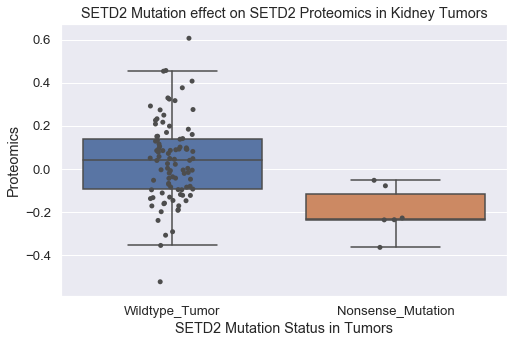

In [10]:
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.2)
rc_cis_boxplot = sns.boxplot(data = formatted_mut_ns,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             order = ['Wildtype_Tumor', mut_1],
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Mutation effect on "+gene+" Proteomics in Kidney Tumors")
rc_cis_boxplot = sns.stripplot(data= formatted_mut_ns, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               order = ['Wildtype_Tumor', mut_1],
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

# Visualize all Mutations

In [11]:
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes=gene, 
                                                        omics_genes=gene,
                                                    mutations_filter=['Nonsense_Mutation'])

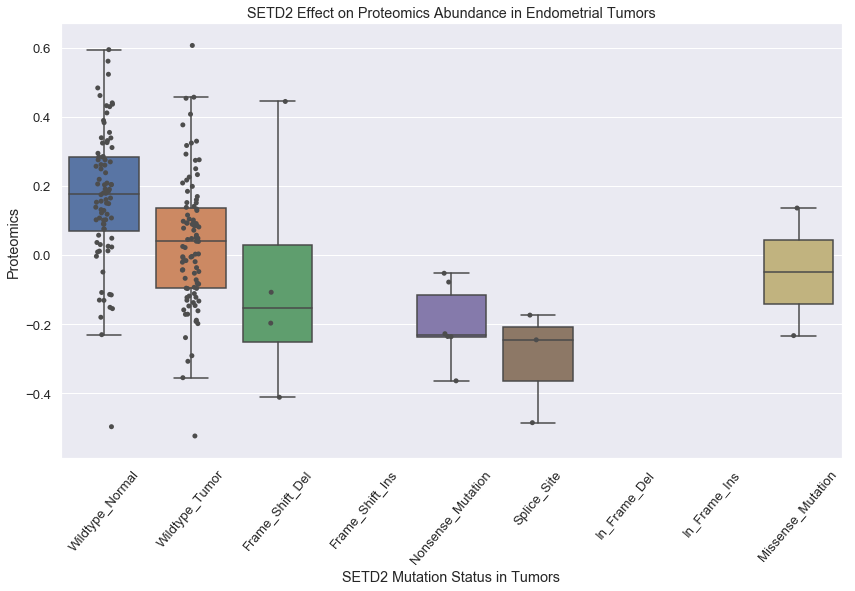

In [12]:
plt.rcParams['figure.figsize']=(14,8)
rc_cis_boxplot = sns.boxplot(data = mutation_prot,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation'],
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= mutation_prot, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation'],
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
rc_cis_boxplot.set_xticklabels(rc_cis_boxplot.get_xticklabels(),rotation = 50)
plt.show()
plt.clf()
plt.close()

# Analysis of Results

SETD2 proteomics decreased in the SETD2 mutated samples compared to the wildtype. SETD2 had more truncation type mutations and no significant difference was found compared to missense type. The most common mutation was nonsense and SETD2 proteomics decreased with this mutation compared to the wildtype.